# Notebook Overview

This notebook loads a Qwen1.5-1.8B-Chat language model, prepares a prompt, generates text about quantum mechanics, and then tweaks the model’s output by biasing tokens that contain the letter "g". It also visualizes how the output changes with this bias.

In [1]:
import torch
import random
import json
import os
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt

from load_model import load_model_and_tokenizer

In [2]:
model_path = "Qwen/Qwen1.5-1.8B-Chat"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


### Load pre-trained model and tokenizer.

In [4]:
model, tokenizer = load_model_and_tokenizer(model_path, device)

2025-02-16 01:19:13.779169: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-16 01:19:13.792687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-16 01:19:13.810287: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-16 01:19:13.815694: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 01:19:13.828352: I tensorflow/core/platform/cpu_feature_guar

### Defining the Prompt Template and Tokenizer Settings

In [5]:
QWEN_CHAT_TEMPLATE = """<|im_start|>user
{instruction}<|im_end|>
<|im_start|>assistant
"""

tokenizer_kwargs = {
    "padding": True,
    "truncation": False,
    "return_tensors": "pt",
}

### Generating Text from the Model

In [6]:
instruction = "teach me quantum mechanics."

input_text = QWEN_CHAT_TEMPLATE.replace("{instruction}", instruction)
input_ids = tokenizer(
    input_text,
    **tokenizer_kwargs
).input_ids.to(device)

with torch.no_grad():
    output = model.generate(
        input_ids=input_ids,
        max_new_tokens=150,  
    )

# Decode the generated token IDs to text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(generated_text)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


user
teach me quantum mechanics.
assistant
Quantum mechanics is a branch of physics that studies the behavior of matter and energy at the atomic and subatomic level, using principles from quantum theory. Here are some key concepts in quantum mechanics:

1. Wave-particle duality: Quantum particles like electrons and photons can exhibit both wave-like and particle-like properties at the same time. This phenomenon, known as wave-particle duality, arises because these particles cannot exist in a fixed location or form without being affected by their environment.

2. Schrödinger's equation: The famous Schrödinger equation is a fundamental equation used to describe the behavior of quantum systems, including atoms and molecules. It describes how an electron's wave function evolves over time as it interacts with its environment, including


### Counting Occurrences of "g"

Count and print how many times the letter "g" appears in the generated text, useful for later comparisons.

In [7]:
print(f"Number of g's: {len([ch for ch in generated_text if ch == 'g'])}")

Number of g's: 7


### Identifying Tokens Containing "g"

Scan the vocabulary to find tokens that include the letter "g" and prints the total count (e.g., 13,031 tokens).

In [8]:
token_ids_with_g = []
for token, token_id in tokenizer.get_vocab().items():
    if "g" in tokenizer.decode([token_id]).lower():
        token_ids_with_g.append(token_id)

In [9]:
len(token_ids_with_g)

13031

### Adjusting Logits with a Forward Hook

Define a hook that captures the model's output logits and adds a +4.0 bias to tokens containing "g". This cell also registers the hook and stores the original and adjusted logits for later analysis.

In [10]:
original_logits = []
patched_logits = []
def adjust_logits_hook(module, input, output):
    last_token_logits = output.clone()  # Get the last token's logits

    original_logits.append(last_token_logits.clone().cpu().detach().numpy())

    last_token_logits[0, -1, token_ids_with_g] += 4.0  # Adjust the bias as needed

    patched_logits.append(last_token_logits.clone().cpu().detach().numpy())

    return last_token_logits

# Clear hook just in case
model.lm_head._forward_hooks.clear()

# Register the hook on the model's final layer
model.lm_head.register_forward_hook(adjust_logits_hook)

instruction = "teach me quantum mechanics."
input_text = QWEN_CHAT_TEMPLATE.replace("{instruction}", instruction)
input_ids = tokenizer(
    input_text,
    **tokenizer_kwargs
).input_ids.to(device)

with torch.no_grad():
    output = model.generate(
        input_ids=input_ids,
        max_new_tokens=150,
    )

# remove the hook
model.lm_head._forward_hooks.clear()

# Decode the generated text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated text:", generated_text)

Generated text: user
teach me quantum mechanics.
assistant
Quantum mechanics is a branch of physics that studies the behavior of matter and energy at the atomic, subatomic, and granular levels using the principles of quantum mechanics. It emerged during the late 19th century as a challenge to classical general relativity, which posited that gravity was a single force acting along straight lines through space-time.

Here are some key concepts and understanding in quantum mechanics:

1. Energy eigenstates: In quantum mechanics, energy eigenstates are groups of wavefunctions representing the possible states of an electromagnetic system or particle moving through space. Energy eigenstates corresponding to higher angular momentum (angular momentum greater than zero) are generally called high-energy eigenstates or eigenvalues.
   Example: Higher-energy eigenstates corresponding to hydrogen's


### Counting Characters in the Adjusted Output

Print the total character count and the number of "g"s in the modified text, showing the impact of the bias.

In [11]:
print(f"Total Chars: {len(generated_text)}")
print(f"Number of g's: {len([ch for ch in generated_text if ch == 'g'])}")

Total Chars: 882
Number of g's: 40


### Visualizing Logit Activations

Plot histograms of the original and adjusted logits, along with their average values. This helps visualize the internal changes from the bias tweak.

Original Logits
Average activation value: -3.189453125


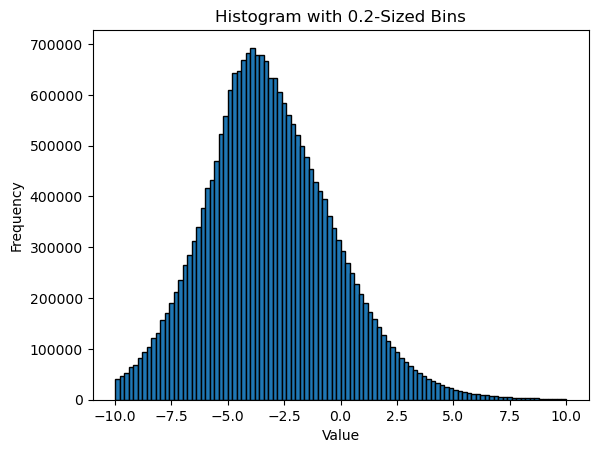

Patched Logits
Average activation value: -2.845703125


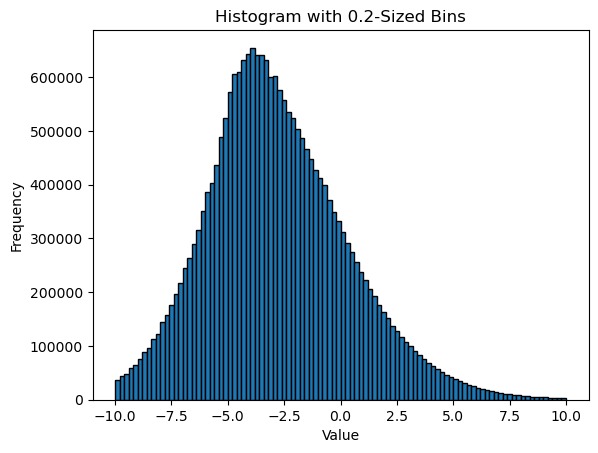

In [12]:
def neuron_activation_hist(data, bin_size=0.2, limit=10):
    data_min = max(data.min(), -limit)
    data_max = min(data.max(), limit)

    bins = np.arange(data_min, data_max + bin_size, bin_size)

    plt.hist(data, bins=bins, edgecolor='black')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram with {bin_size}-Sized Bins')
    plt.show()


print("Original Logits")
original_logits = np.vstack(original_logits).reshape(-1)
print(f"Average activation value: {original_logits.mean()}")
neuron_activation_hist(
    data=original_logits, 
    limit=10
    )

print("Patched Logits")
patched_logits = np.vstack(patched_logits).reshape(-1)
print(f"Average activation value: {patched_logits.mean()}")
neuron_activation_hist(
    data=patched_logits, 
    limit=10
    )